### A/334 Parameter Specification
- Autocorrection Delay = 3ms
- Sysmbol interval T = 1/106 seconds
- Marking Frequency Band = 2.5kHz - 5.0kHz

### Sample 
- frequency 48kHz -> 48000 frames/second
- Symbol frames 48000/106 = ca. 453 frames

### Help


In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf
from scipy.signal import butter, lfilter
from pydub import AudioSegment

In [2]:
audioSegment = AudioSegment.from_file("video.ts")
sig = np.frombuffer(audioSegment.raw_data, dtype='<i4').reshape(-1, audioSegment.channels)
samplerate = audioSegment.frame_rate

In [3]:
offset_sec = 0.003
offset_frames = int(samplerate * offset_sec)
symbols_per_sec = 106
samples_per_symbol = samplerate / symbols_per_sec
samples_per_symbol

452.8301886792453

In [4]:
#https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [5]:
sig_bandpassed = butter_bandpass_filter(sig[:, 0], 2500, 5000, samplerate)

C:\Users\Janbe\AppData\Local\pypoetry\Cache\virtualenvs\video-watermark-decoder-evsskYxq-py3.10\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


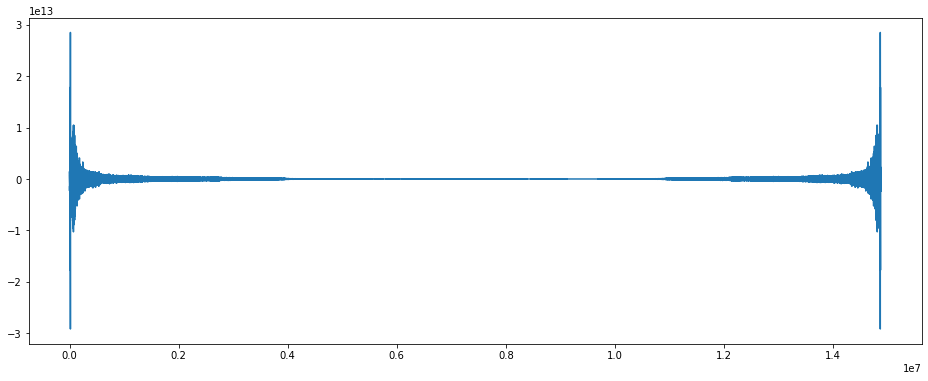

In [6]:
sig_fft = np.fft.fft(sig[:, 0])

plt.figure(figsize=(16, 6))
plt.plot(sig_fft)

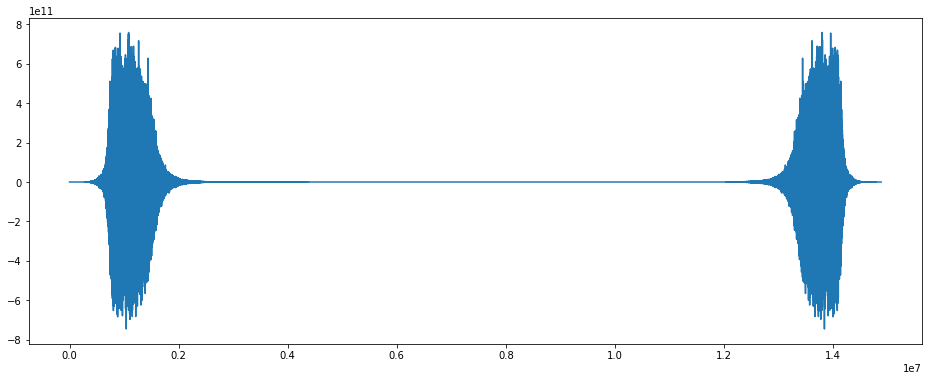

In [7]:
sig_fft = np.fft.fft(sig_bandpassed)

plt.figure(figsize=(16, 6))
plt.plot(sig_fft)

should be 441.6666666666667 symbols
Time to run: 0.91 seconds


C:\Users\Janbe\AppData\Local\Temp\ipykernel_14832\1538998010.py:14: RuntimeWarning: invalid value encountered in true_divide
  diffs_fast = diffs_fast / np.abs(diffs_fast)


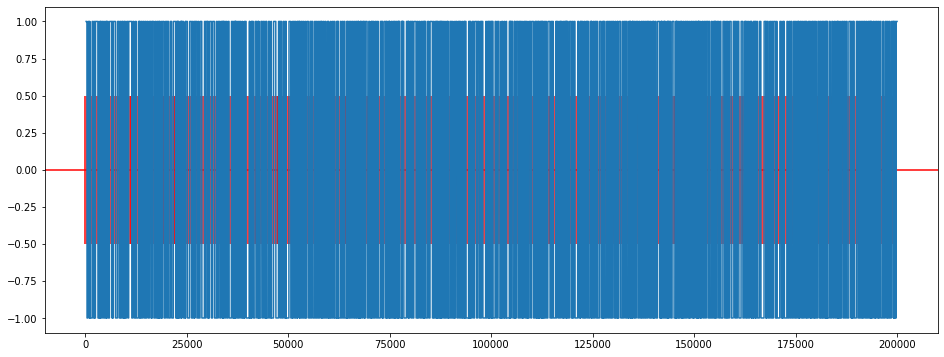

In [8]:
start_time = time.time()
samples_fast = 200000
print(f"should be {symbols_per_sec * samples_fast / samplerate} symbols")
sigg = sig_bandpassed
diffs_fast = np.zeros(samples_fast)
for i in range(int(samples_per_symbol/2), samples_fast):
    # TODO get rid of range and maybe average it
    first_half_acf = np.correlate(sigg[i:int(samples_per_symbol/2)+i], sigg[i-offset_frames:int(samples_per_symbol/2)+i-offset_frames])
    second_half_acf = np.correlate(sigg[i+int(samples_per_symbol/2):i+int(samples_per_symbol)], sigg[i+int(samples_per_symbol/2)-offset_frames:i+int(samples_per_symbol)-offset_frames])
    diffs_fast[i] = first_half_acf[0] - second_half_acf[0]
    
#diffs_fast = np.maximum(-1, diffs_fast)
#diffs_fast = np.minimum(1, diffs_fast)
diffs_fast = diffs_fast / np.abs(diffs_fast)

plt.figure(figsize=(16, 6))
plt.vlines(np.arange(50,samples_fast, samples_per_symbol), -0.5, 0.5, colors=["red"])
plt.axhline(y=0, color='r', linestyle='-')
plt.plot(diffs_fast, '-')
print(f"Time to run: {(time.time() - start_time):.2f} seconds")

Time to run: 23.27 seconds


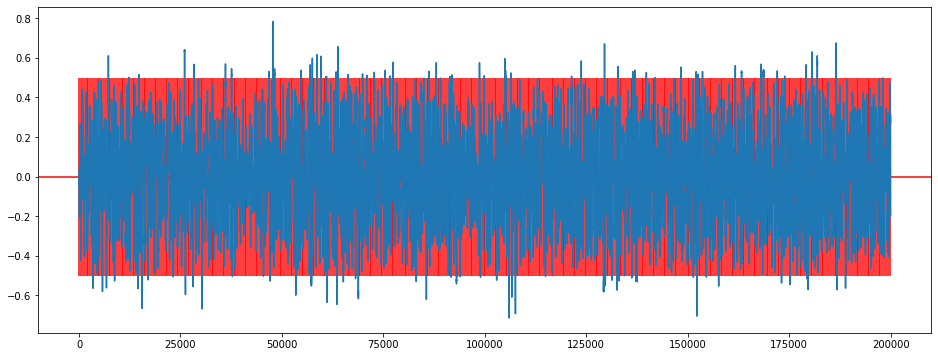

In [9]:
start_time = time.time()
samples = 200000
sigg = sig_bandpassed
diffs = np.zeros(samples)
for i in range(samples):
    # TODO get rid of range and maybe average it
    orig_acf = acf(sigg[i:int(samples_per_symbol/2)+i], nlags=offset_frames)
    delay_acf = acf(sigg[i+int(samples_per_symbol/2):i+int(samples_per_symbol)], nlags=offset_frames)
    diffs[i] = orig_acf[-1] - delay_acf[-1]

plt.figure(figsize=(16, 6))
plt.vlines(np.arange(50,samples, samples_per_symbol), -0.5, 0.5, colors=["red"])
plt.axhline(y=0, color='r', linestyle='-')
plt.plot(diffs, '-')
print(f"Time to run: {(time.time() - start_time):.2f} seconds")

In [10]:
MESSAGE_HEADER = '10101110000010101011100111100100'
for i in range(samples-3000):
    is_correct = True
    for j in range(len(MESSAGE_HEADER)):
        if not (diffs[int(j*samples_per_symbol+i)] >= 0 and MESSAGE_HEADER[j] == '1' or diffs[int(j*samples_per_symbol+i)] < 0 and MESSAGE_HEADER[j] == '0'):
            is_correct = False
            break
    if is_correct:
        print(f"found offset for message start {i}")

found offset for message start 71894
found offset for message start 71895
found offset for message start 71896
found offset for message start 71897
found offset for message start 71898
found offset for message start 71899
found offset for message start 71900
found offset for message start 71901
found offset for message start 71939
found offset for message start 71940
found offset for message start 71941
found offset for message start 71942
found offset for message start 71943
found offset for message start 71944
found offset for message start 71945
found offset for message start 71946
found offset for message start 71947
found offset for message start 71948
found offset for message start 71949
found offset for message start 71950
found offset for message start 71951
found offset for message start 71952
found offset for message start 71953
found offset for message start 71954
found offset for message start 71955
found offset for message start 71956
found offset for message start 71957
f

In [11]:
MESSAGE_HEADER = '10101110000010101011100111100100'
for i in range(samples_fast-3000):
    is_correct = True
    for j in range(len(MESSAGE_HEADER)):
        if not (diffs_fast[int(j*samples_per_symbol+i)] >= 0 and MESSAGE_HEADER[j] == '1' or diffs_fast[int(j*samples_per_symbol+i)] < 0 and MESSAGE_HEADER[j] == '0'):
            is_correct = False
            break
    if is_correct:
        print(f"found offset for message start {i}")

found offset for message start 71984
found offset for message start 71985
found offset for message start 71986
found offset for message start 71987
found offset for message start 71988
found offset for message start 71989
found offset for message start 71990
found offset for message start 71991
found offset for message start 71992
found offset for message start 71993
found offset for message start 71994
found offset for message start 71995
found offset for message start 71996
found offset for message start 71997
found offset for message start 71998
found offset for message start 71999
found offset for message start 72000
found offset for message start 72001
found offset for message start 72002
found offset for message start 72003
found offset for message start 72004
found offset for message start 72005
found offset for message start 72006
found offset for message start 72007
found offset for message start 72008
found offset for message start 72009
found offset for message start 72010
f

In [12]:
15000 / samples_per_symbol

33.125